In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd
from sklearn.externals import joblib
from sklearn import metrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Bar, Scatter, Figure, Layout, Pie, Box
from plotly import tools

init_notebook_mode(connected=True)#run at the start of every ipython notebook to use plotly.offline

# Loading Test Dataset

In [2]:
headers = ['sentiment', 'id', 'date', 'query', 'user', 'tweet']
data = pd.read_csv('data/testdata.manual.2009.06.14.csv', names=headers)
data.head()

,sentiment,id,date,query,user,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


# Data Distribution

In [3]:
data = data[data['sentiment'] != 2]
neg = len(data[data["sentiment"] == 0])
pos = len(data[data["sentiment"] == 4])
neu = len(data[data["sentiment"] == 2])
dist = [Bar(
        x=["negative","neutral","positive"],
        y=[neg, neu, pos],
)]
iplot({"data":dist, "layout":Layout(title="Sentiment type distribution in training set")})

In [4]:
data.drop(['id','date','query','user'],axis=1,inplace=True)
data.head()

,sentiment,tweet
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


# Data Preprocessing

In [5]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
import re
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9]+' #remove username
pat2 = r'https?://[A-Za-z0-9./]+' #remove url that starts with http or https
pat3 = r'www.[^ ]+' #remove url that starts with www
pat4 = r'\s?[0-9]+\.?[0-9]*'#remove numbers
combined_pat = r'|'.join((pat1, pat2, pat3, pat4))

# handle negation patterns
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    lower_case = clean.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [6]:
data['tweet'] = map(lambda text:tweet_cleaner(text),data['tweet'])
data['pre_clean_len'] = [len(t) for t in data.tweet]
data.head()

/Users/rupeshkarn/miniconda2/lib/python2.7/encodings/utf_8_sig.py:19: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



,sentiment,tweet,pre_clean_len
0,4,loooooooovvvvvveee my kindle not that the dx i...,90
1,4,reading my kindle love it lee childs is good read,49
2,4,ok first assesment of the kindle it fucking rocks,49
3,4,you ll love your kindle ve had mine for few mo...,116
4,4,fair enough but have the kindle and think it p...,52


In [7]:
box_plot = [Box(y=data['pre_clean_len'])]
data.drop(['pre_clean_len'],axis=1,inplace=True)
iplot({"data":box_plot, "layout":Layout(title="Tweet length distribution")})

# Loading and evaluating the model

In [8]:
model = joblib.load('sentiment.model')

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from time import time
import pylab
pylab.rcParams['figure.figsize'] = (12, 6)

def train_test_and_evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print "Accuracy score: {0:.2f}%".format(accuracy*100)
    print "-"*80
    print "Confusion Matrix\n"
    print confusion
    print "-"*80
    print "Classification Report\n"
    print classification_report(y_test, y_pred, target_names=['negative','positive'])
    skplt.metrics.plot_precision_recall_curve(y_test, y_prob)
    plt.show()
    skplt.metrics.plot_roc_curve(y_test, y_prob)
    plt.show()

Accuracy score: 81.62%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 132                   0
positive                   0                   0
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.86      0.75      0.80       177
   positive       0.78      0.88      0.83       182

avg / total       0.82      0.82      0.82       359



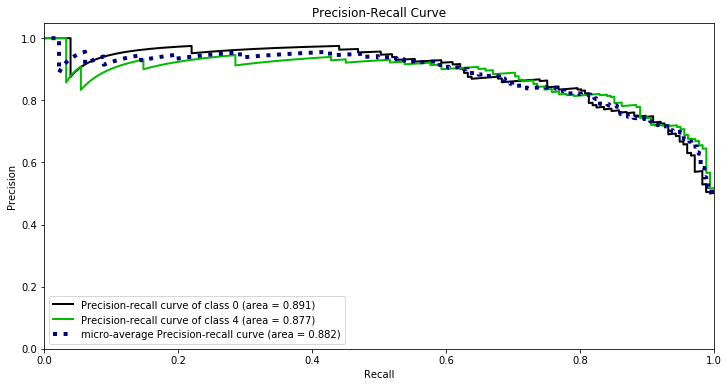

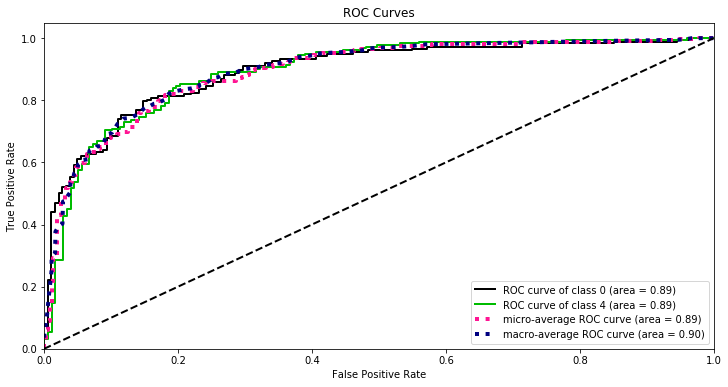

CPU times: user 3.15 s, sys: 2.7 s, total: 5.84 s
Wall time: 8.97 s


In [10]:
%%time
train_test_and_evaluate(model, data.tweet, data.sentiment)